# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import pandas as pd

In [2]:
# input file containing the surface reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'

# cti_file = '../RMG-model/cantera/chem0050.cti'

gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [3]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [  +63 minor]              0                0



In [4]:
print(", ".join(gas.species_names))

Ne, NH3(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), O(36), Ar(37), He(38), HO2(39), H2O2(40), HOCO(41), CH2(42), CH2(S)(43), CH(44), CH2OH(45), CH3O(46), HCOH(47), CH3OO(48), CH2CO(49), C2H3(50), C(51), C2H2(52), C2H(53), CH3OOH(54), CH2OOH(55), HOCH2O(56), HOCHO(57), C2H5O(58), C2H5O2(59), C2H5O2(60), cC2H4O(61), CH2CHO(62), H2CC(63), CH3CO(64), C2H4O(65), C2H5O(66), C2H3O2(67), CHCHO(68), OCHCHO(69), NH2(85), H2NO(88), HNOH(93), NO3(95), H2NO3(239)


In [5]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(201), H3NX(202), H2NOX(203), H2NOX(204), H3NOX(205), NO2X(206), NO3X(207), HNO3X(208), CH3OX(209), CH3OX(210), CH4OX(211)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [6]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [7]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
temperature_c = 400.0  # Initial Temperature in Celsius
pressure = ct.one_atm # constant

length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
cat_specific_area = 140 # m2/g
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_vol = cat_specific_area * cat_density # m2/m3
cat_area_per_vol *= 1e-4 # REDUCE BY A LOT
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print()

porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter

Catalyst density 2.00e+06 g/m3
Catalyst area per volume 2.80e+04 m2/m3



In [8]:
output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2001
# dt = 1.0

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# From HAN-molefractions.ipynb
feed_mole_fractions = {
    'NH3(2)': 0.0304738,
    'NH2OH(3)': 0.450974,
    'HNO3(4)': 0.481448,
    'CH3OH(5)': 0.0325297,
    'H2O(6)': 0.00457386,
}
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions


# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['gas_heat','surface_heat','alpha'])

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

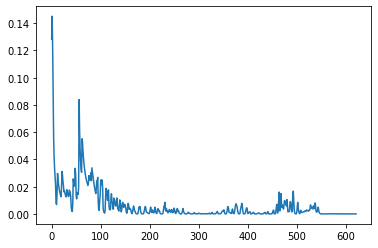


  surface1:

       temperature         677.801  K
          pressure          101325  Pa
           density      5.4607e-06  kg/m^3
  mean mol. weight         211.082  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -8.7253e+05       -1.842e+08     J
   internal energy     -8.7253e+05       -1.842e+08     J
           entropy          152.07         3.21e+04     J/K
    Gibbs function      -9.756e+05       -2.059e+08     J
 heat capacity c_p          111.53        2.354e+04     J/K
 heat capacity c_v          111.53        2.354e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              X(1)    1.12216e-10       1.0371e-10         -22.9106
            OX(27)              1                1         -36.5416
           HOX(29)    8.17117e-12      8.21018e-12         -63.3832
          H2OX(30)    3

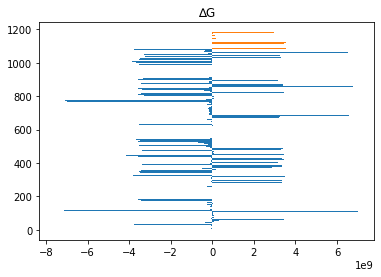

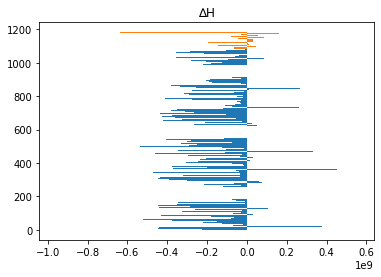

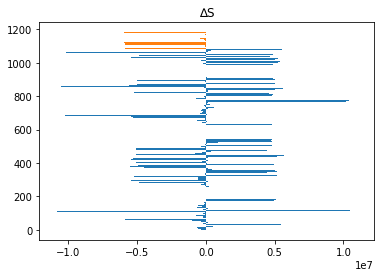

array([ 1.12215654e-10,  2.07828559e-20,  9.99999997e-01, -9.98646039e-44,
        8.17116646e-12,  3.96984886e-14,  2.27515819e-19,  1.87845529e-23,
        1.78600369e-44,  1.75957434e-49,  5.39313890e-40,  1.37140273e-32,
        2.30209763e-37,  5.46051352e-55,  8.87654110e-33,  3.10871134e-40,
        3.65831240e-11,  4.09882382e-20,  1.18786815e-21,  1.28138631e-41,
        1.99498650e-33,  1.26891162e-44])

In [9]:
# To find the starting coverages, we run the gas to equilibrium,
# (i.e mostly burned products)  then put that in steady state
# with the surface.
TPY = gas.TPY # store to restore
gas.equilibrate('TP')
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
sim = ct.ReactorNet([r])
plt.plot(sim.advance_to_steady_state(return_residuals=True))
plt.show()
surf()
starting_coverages = surf.coverages

print("At equilibrium")
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

gas.TPY = TPY # restore to starting conditions
del(r, rsurf)
starting_coverages

<BarContainer object of 64 artists>

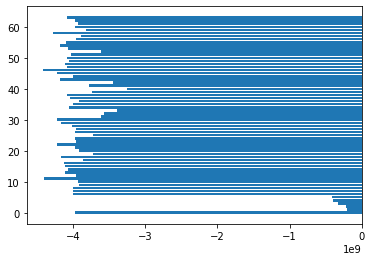

In [10]:
plt.barh(np.arange(len(gas.chemical_potentials)),gas.chemical_potentials)

In [11]:
# gas.equilibrate('TP')

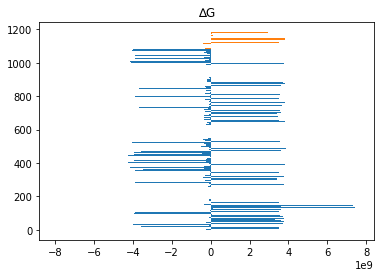

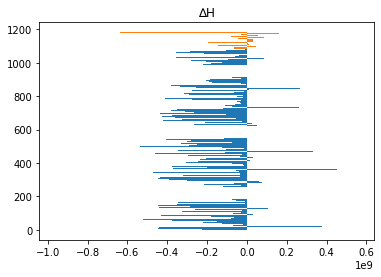

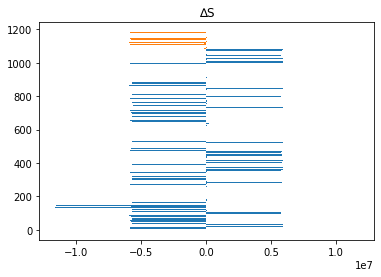

In [12]:
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

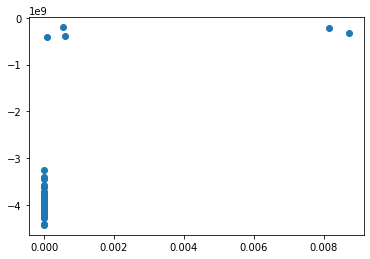

In [13]:
plt.plot(gas.concentrations, gas.chemical_potentials, 'o')

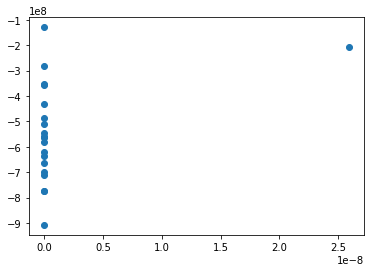

In [14]:
plt.plot(surf.concentrations, surf.chemical_potentials, 'o')

In [15]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)               -0.004
 64 : NH2OH(3) (+M) <=> NH2(85) + OH(24) (+M)              1e-08
 82 : H2NO(88) + H2NO3(239) <=> HNO3(4) + NH2OH(3)        -2e-10
 75 : H(20) + H2NO(88) <=> NH2OH(3)                       -5e-12
 95 : H2NO3(239) + HNOH(93) <=> HNO3(4) + NH2OH(3)        -3e-14
 94 : H(20) + HNOH(93) <=> NH2OH(3)                       -3e-15
 42 : CH3(18) + OH(24) <=> CH3OH(5)                       -8e-18

Highest net rates of progress, surface
  2 : H2O(6) + X(1) <=> H2OX(30)                          -4e-06
  0 : NH2OH(3) + X(1) <=> H3NOX(205)                       4e-07
  1 : HNO3(4) + X(1) <=> HNO3X(208)                        3e-07
  3 : NH3(2) + X(1) <=> H3NX(202)                          4e-08
  4 : CH3OH(5) + X(1) <=> CH4OX(211)                       3e-08
 57 : CO2(12) + X(1) <=> CO2X(31)                         -6e-10
 46 : H2OX(30) + OX(27) <=> 2 HOX(29)                     -5e-10

Highest forwa

In [16]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
891 : 2 CH3CO(64) <=> CH2CO(49) + CH3CHO(23)             5.4e+11
872 : C2H5(21) + CH3CO(64) <=> C2H4(25) + CH3CHO(23)     5.4e+11
868 : CH3CO(64) + CH3O(46) <=> CH2O(17) + CH3CHO(23)     5.4e+11
655 : C2H5(21) + HOCO(41) <=> C2H4(25) + HOCHO(57)       5.4e+11
888 : CH3CO(64) + HCO(22) <=> CH2CO(49) + CH2O(17)       5.4e+11
905 : CH3CO(64) + HOCO(41) <=> CH2CO(49) + HOCHO(57)     5.4e+11
660 : CH3O(46) + HOCO(41) <=> CH2O(17) + HOCHO(57)       5.4e+11

Highest forward rate constants, surface
 77 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 62 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 76 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                 1.8e+19
 65 : CH2X(34) + HOX(29) <=> CH3X(28) + OX(27)           9.2e+18
 88 : CHX(35) + HOX(29) <=> CH2X(34) + OX(27)            4.6e+18
 61 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18

Highest rev

In [17]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-20

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster


print('    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha')
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY

    upstream.syncState()
    sim.reinitialize()
    try:
#         the default is residual_threshold = sim.rtol*10
#         sim.advance_to_steady_state(residual_threshold = sim.rtol*1e3)
        sim.advance_to_steady_state()

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        r.syncState()
        sim.reinitialize()
        print(f"Couldn't reach {t:.1g} s so going to {0.1*t:.1g} s")
        sim.advance(0.1*t)
        report_rates()
        report_rate_constants()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surface_heat = cat_area_per_vol * np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = surface_heat / (surface_heat + gas_heat) # fraction of heat release that is on surface.

    if not n % 10:
        print('    {:10f}  {:7.1f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, r.T-273.15, *gas['NH3(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [gas_heat, surface_heat, alpha])
    
    #report_rates()
    #report_rate_constants()

outfile.close()
print("Results saved to '{0}'".format(output_filename))

    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha
      0.000000    400.0    0.030510    0.450851    0.481430   0.032527  1.0e+00
      0.055000    400.2    0.030873    0.449623    0.481252   0.032505  1.0e+00
      0.110000    400.5    0.031233    0.448406    0.481075   0.032483  1.0e+00
      0.165000    400.7    0.031589    0.447198    0.480900   0.032462  1.0e+00
      0.220000    400.9    0.031943    0.446000    0.480726   0.032440  1.0e+00
      0.275000    401.1    0.032294    0.444811    0.480553   0.032419  1.0e+00
      0.330000    401.3    0.032642    0.443632    0.480382   0.032398  1.0e+00
      0.385000    401.5    0.032987    0.442463    0.480212   0.032377  1.0e+00
      0.440000    401.7    0.033330    0.441302    0.480043   0.032356  1.0e+00
      0.495000    402.0    0.033669    0.440151    0.479876   0.032335  1.0e+00
      0.550000    402.2    0.034006    0.439008    0.479710   0.032315  1.0e+00
      0.605000    402.4    0.034341    0.

      5.610000    416.1    0.057019    0.360516    0.468154   0.030959  1.0e+00
      5.665000    416.3    0.057208    0.359867    0.468056   0.030948  1.0e+00
      5.720000    416.4    0.057396    0.359222    0.467959   0.030937  1.0e+00
      5.775000    416.5    0.057583    0.358580    0.467863   0.030926  1.0e+00
      5.830000    416.6    0.057769    0.357941    0.467767   0.030915  1.0e+00
      5.885000    416.7    0.057954    0.357305    0.467671   0.030904  1.0e+00
      5.940000    416.8    0.058138    0.356673    0.467576   0.030894  1.0e+00
      5.995000    416.9    0.058322    0.356043    0.467481   0.030883  1.0e+00
      6.050000    417.1    0.058504    0.355416    0.467387   0.030872  1.0e+00
      6.105000    417.2    0.058686    0.354793    0.467293   0.030862  1.0e+00
      6.160000    417.3    0.058867    0.354172    0.467199   0.030851  1.0e+00
      6.215000    417.4    0.059047    0.353554    0.467106   0.030841  1.0e+00
      6.270000    417.5    0.059226    0

In [18]:
sim.time

103985.63188911356

In [19]:
gas.TDY = TDY
r.syncState()
r.thermo.T

698.4876384095786

In [20]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
rsurf.kinetics.net_rates_of_progress

array([ 2.87393827e-05,  2.12888320e-08, -9.81123494e-06, -1.00354549e-05,
        2.33267074e-07,  1.26348528e-16,  3.29691416e-16,  3.33587904e-12,
        3.97773790e-13,  6.30415157e-18, -5.47199565e-12,  3.80512637e-12,
        1.15655510e-13,  1.67897655e-12,  5.62119640e-10,  2.99640452e-16,
        1.66807751e-12,  4.21360901e-12,  5.58448719e-07,  1.81122290e-12,
       -1.23260568e-09,  1.21178342e-09, -1.04515009e-11, -2.72185447e-17,
        4.98030581e-13,  7.98416109e-13, -3.84670573e-14, -6.48758747e-25,
       -4.38536425e-22,  1.66011208e-13, -2.40886025e-26,  2.20554815e-19,
        1.83307754e-16,  1.66010193e-13,  3.40301708e-16, -3.84748413e-14,
       -3.04316115e-10,  3.04311821e-12, -1.86914915e-05, -4.09627755e-09,
        2.33419873e-13,  1.27611804e-11,  6.28055520e-14,  2.28700833e-16,
       -5.09240607e-16, -9.60097007e-06, -9.81041532e-06,  9.81148413e-36,
        3.89484225e-16,  1.77181807e-18,  2.81267945e-05,  5.87498842e-07,
       -2.28360184e-12, -

In [22]:
surf.net_rates_of_progress

array([ 2.87393827e-05,  2.12888320e-08, -9.81123494e-06, -1.00354549e-05,
        2.33267074e-07,  1.26348528e-16,  3.29691416e-16,  3.33587904e-12,
        3.97773790e-13,  6.30415157e-18, -5.47199565e-12,  3.80512637e-12,
        1.15655510e-13,  1.67897655e-12,  5.62119640e-10,  2.99640452e-16,
        1.66807751e-12,  4.21360901e-12,  5.58448719e-07,  1.81122290e-12,
       -1.23260568e-09,  1.21178342e-09, -1.04515009e-11, -2.72185447e-17,
        4.98030581e-13,  7.98416109e-13, -3.84670573e-14, -6.48758747e-25,
       -4.38536425e-22,  1.66011208e-13, -2.40886025e-26,  2.20554815e-19,
        1.83307754e-16,  1.66010193e-13,  3.40301708e-16, -3.84748413e-14,
       -3.04316115e-10,  3.04311821e-12, -1.86914915e-05, -4.09627755e-09,
        2.33419873e-13,  1.27611804e-11,  6.28055520e-14,  2.28700833e-16,
       -5.09240607e-16, -9.60097007e-06, -9.81041532e-06,  9.81148413e-36,
        3.89484225e-16,  1.77181807e-18,  2.81267945e-05,  5.87498842e-07,
       -2.28360184e-12, -

In [23]:
gas.TDY

(698.4876384095786,
 0.7830701705069525,
 array([1.16670393e-259, 2.73193805e-002, 2.27297456e-001, 6.46105993e-001,
        2.14737575e-002, 1.88344275e-002, 4.65742845e-011, 7.79332244e-009,
        7.78914871e-004, 2.58010259e-007, 9.46521928e-008, 1.01715555e-003,
        4.32415073e-011, 3.96121893e-006, 7.47011489e-013, 1.38523501e-022,
        1.54648220e-005, 3.44274387e-016, 3.18592096e-033, 8.85313492e-015,
        2.86387909e-026, 6.29937914e-011, 3.21901418e-019, 7.08218130e-009,
        1.65170717e-019, 5.82876074e-016, 0.00000000e+000, 0.00000000e+000,
        3.06774771e-011, 8.26605300e-010, 7.96916595e-016, 4.05631186e-022,
        2.50922409e-024, 3.61314952e-031, 1.07271634e-009, 2.88135811e-010,
        2.90022734e-020, 3.26851888e-013, 7.51524822e-018, 5.20746899e-028,
        7.64313574e-035, 1.55105521e-024, 1.81235894e-037, 2.89053360e-012,
        5.57710469e-022, 4.38382042e-017, 5.92646574e-011, 8.16681083e-024,
        3.63319897e-027, 3.08247032e-034, 1.095

In [24]:
r.thermo.TDY

(698.4876384095786,
 0.7830701705069525,
 array([1.16670393e-259, 2.73193805e-002, 2.27297456e-001, 6.46105993e-001,
        2.14737575e-002, 1.88344275e-002, 4.65742845e-011, 7.79332244e-009,
        7.78914871e-004, 2.58010259e-007, 9.46521928e-008, 1.01715555e-003,
        4.32415073e-011, 3.96121893e-006, 7.47011489e-013, 1.38523501e-022,
        1.54648220e-005, 3.44274387e-016, 3.18592096e-033, 8.85313492e-015,
        2.86387909e-026, 6.29937914e-011, 3.21901418e-019, 7.08218130e-009,
        1.65170717e-019, 5.82876074e-016, 0.00000000e+000, 0.00000000e+000,
        3.06774771e-011, 8.26605300e-010, 7.96916595e-016, 4.05631186e-022,
        2.50922409e-024, 3.61314952e-031, 1.07271634e-009, 2.88135811e-010,
        2.90022734e-020, 3.26851888e-013, 7.51524822e-018, 5.20746899e-028,
        7.64313574e-035, 1.55105521e-024, 1.81235894e-037, 2.89053360e-012,
        5.57710469e-022, 4.38382042e-017, 5.92646574e-011, 8.16681083e-024,
        3.63319897e-027, 3.08247032e-034, 1.095

In [25]:
report_rate_constants()


Highest forward rate constants, gas
868 : CH3CO(64) + CH3O(46) <=> CH2O(17) + CH3CHO(23)     5.4e+11
905 : CH3CO(64) + HOCO(41) <=> CH2CO(49) + HOCHO(57)     5.4e+11
655 : C2H5(21) + HOCO(41) <=> C2H4(25) + HOCHO(57)       5.4e+11
660 : CH3O(46) + HOCO(41) <=> CH2O(17) + HOCHO(57)       5.4e+11
888 : CH3CO(64) + HCO(22) <=> CH2CO(49) + CH2O(17)       5.4e+11
891 : 2 CH3CO(64) <=> CH2CO(49) + CH3CHO(23)             5.4e+11
872 : C2H5(21) + CH3CO(64) <=> C2H4(25) + CH3CHO(23)     5.4e+11

Highest forward rate constants, surface
 62 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 77 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 76 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                 1.9e+19
 65 : CH2X(34) + HOX(29) <=> CH3X(28) + OX(27)           1.0e+19
 88 : CHX(35) + HOX(29) <=> CH2X(34) + OX(27)            5.8e+18
 61 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18

Highest rev

In [26]:
sim.verbose

False

In [27]:
sim.component_name(46)

'IdealGasReactor_2: CH3OOH(54)'

<BarContainer object of 1082 artists>

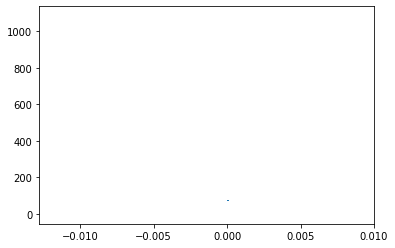

In [28]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [29]:
gas.T

698.4876384095786

In [30]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,NH3(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,H3NOX(205),NO2X(206),NO3X(207),HNO3X(208),CH3OX(209),CH3OX(210),CH4OX(211),gas_heat,surface_heat,alpha
0,0.0000,400.022258,1.0,0.000000e+00,0.030510,0.450851,0.481430,0.032527,0.004610,2.781610e-22,...,0.000020,0.088136,0.000002,0.000036,9.249906e-12,0.001637,4.170907e-08,231601.406975,-3.335483e+07,1.006992
1,0.0055,400.044514,1.0,0.000000e+00,0.030547,0.450728,0.481413,0.032525,0.004647,1.808936e-21,...,0.000020,0.088563,0.000003,0.000036,9.243962e-12,0.001635,4.168146e-08,204380.456047,-3.332549e+07,1.006171
2,0.0110,400.066759,1.0,0.000000e+00,0.030583,0.450605,0.481395,0.032523,0.004684,5.693305e-21,...,0.000020,0.088990,0.000003,0.000036,9.238029e-12,0.001633,4.165390e-08,191652.800479,-3.329620e+07,1.005789
3,0.0165,400.088990,1.0,0.000000e+00,0.030619,0.450482,0.481377,0.032521,0.004720,1.294809e-20,...,0.000020,0.089415,0.000003,0.000036,9.232106e-12,0.001631,4.162637e-08,181497.275971,-3.326696e+07,1.005486
4,0.0220,400.111208,1.0,0.000000e+00,0.030656,0.450359,0.481359,0.032519,0.004757,2.453252e-20,...,0.000020,0.089840,0.000004,0.000036,9.226194e-12,0.001629,4.159887e-08,173147.873611,-3.323777e+07,1.005237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,10.9780,425.314556,1.0,2.595020e-259,0.071960,0.308991,0.460226,0.030081,0.046884,7.399325e-11,...,0.000006,0.371657,0.000009,0.000013,5.073148e-12,0.000455,1.861822e-08,347916.555241,-1.187895e+07,1.030172
1997,10.9835,425.322253,1.0,2.594985e-259,0.071973,0.308948,0.460219,0.030080,0.046897,7.420172e-11,...,0.000006,0.371710,0.000009,0.000013,5.072335e-12,0.000455,1.861339e-08,348009.355962,-1.187493e+07,1.030191
1998,10.9890,425.329947,1.0,2.594949e-259,0.071985,0.308904,0.460212,0.030080,0.046910,7.441068e-11,...,0.000006,0.371763,0.000009,0.000013,5.071522e-12,0.000455,1.860857e-08,348102.135928,-1.187092e+07,1.030210
1999,10.9945,425.337638,1.0,2.594914e-259,0.071998,0.308861,0.460205,0.030079,0.046923,7.462014e-11,...,0.000006,0.371817,0.000009,0.000013,5.070710e-12,0.000455,1.860375e-08,348194.895136,-1.186690e+07,1.030229


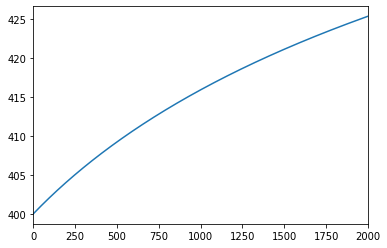

In [31]:
data['T (C)'].plot()

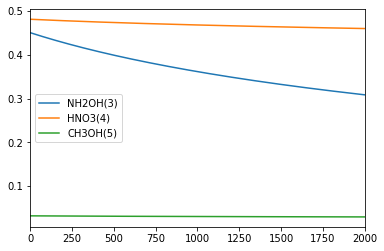

In [32]:
data[['NH2OH(3)', 'HNO3(4)', 'CH3OH(5)']].plot()

In [33]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

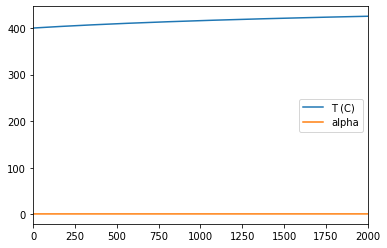

In [34]:
data[['T (C)', 'alpha']].plot()

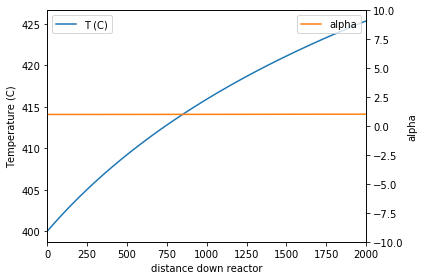

In [35]:
ax1 = data['T (C)'].plot()
plt.xlabel('distance down reactor')
plt.ylabel('Temperature (C)')
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-10, 10)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [36]:
data.columns

Index(['Distance (mm)', 'T (C)', 'P (atm)', 'Ne', 'NH3(2)', 'NH2OH(3)',
       'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)', 'O2(8)', 'NO2(9)', 'NO(10)',
       'N2O(11)', 'CO2(12)', 'H2(13)', 'CO(14)', 'CH4(15)', 'C2H6(16)',
       'CH2O(17)', 'CH3(18)', 'C3H8(19)', 'H(20)', 'C2H5(21)', 'HCO(22)',
       'CH3CHO(23)', 'OH(24)', 'C2H4(25)', 'O(36)', 'Ar(37)', 'He(38)',
       'HO2(39)', 'H2O2(40)', 'HOCO(41)', 'CH2(42)', 'CH2(S)(43)', 'CH(44)',
       'CH2OH(45)', 'CH3O(46)', 'HCOH(47)', 'CH3OO(48)', 'CH2CO(49)',
       'C2H3(50)', 'C(51)', 'C2H2(52)', 'C2H(53)', 'CH3OOH(54)', 'CH2OOH(55)',
       'HOCH2O(56)', 'HOCHO(57)', 'C2H5O(58)', 'C2H5O2(59)', 'C2H5O2(60)',
       'cC2H4O(61)', 'CH2CHO(62)', 'H2CC(63)', 'CH3CO(64)', 'C2H4O(65)',
       'C2H5O(66)', 'C2H3O2(67)', 'CHCHO(68)', 'OCHCHO(69)', 'NH2(85)',
       'H2NO(88)', 'HNOH(93)', 'NO3(95)', 'H2NO3(239)', 'X(1)', 'HX(26)',
       'OX(27)', 'CH3X(28)', 'HOX(29)', 'H2OX(30)', 'CO2X(31)', 'OCX(32)',
       'CX(33)', 'CH2X(34)', 'CHX(35)

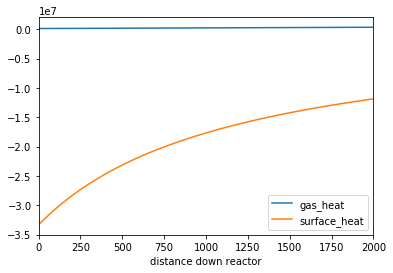

In [53]:
data[['gas_heat','surface_heat']].plot()
#plt.ylim(-1e7, 1e7)
plt.xlabel('distance down reactor')
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


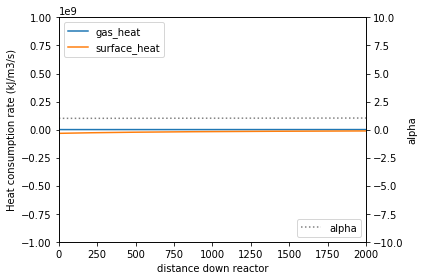

In [38]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
plt.xlabel('distance down reactor')
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('heats-and-alpha.pdf')
plt.show()

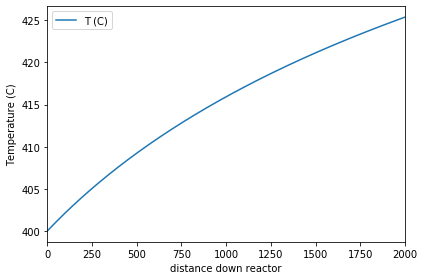

In [39]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
plt.xlabel('distance down reactor')
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

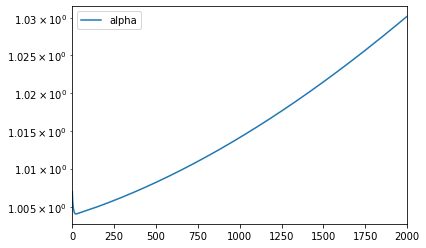

In [40]:
data[['alpha']].plot(logy=True)

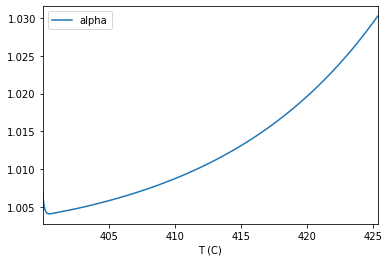

In [41]:
data.plot(x='T (C)',y='alpha')

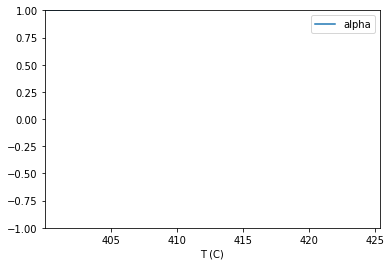

In [42]:
data.plot(x='T (C)',y='alpha', ylim=(-1,1))

In [43]:
specs = list(data.columns)
specs = specs[4:-1]

gas_species = [s for s in specs if 'X' not in s]
adsorbates = [s for s in specs if 'X' in s]

gas_species, adsorbates

(['NH3(2)',
  'NH2OH(3)',
  'HNO3(4)',
  'CH3OH(5)',
  'H2O(6)',
  'N2(7)',
  'O2(8)',
  'NO2(9)',
  'NO(10)',
  'N2O(11)',
  'CO2(12)',
  'H2(13)',
  'CO(14)',
  'CH4(15)',
  'C2H6(16)',
  'CH2O(17)',
  'CH3(18)',
  'C3H8(19)',
  'H(20)',
  'C2H5(21)',
  'HCO(22)',
  'CH3CHO(23)',
  'OH(24)',
  'C2H4(25)',
  'O(36)',
  'Ar(37)',
  'He(38)',
  'HO2(39)',
  'H2O2(40)',
  'HOCO(41)',
  'CH2(42)',
  'CH2(S)(43)',
  'CH(44)',
  'CH2OH(45)',
  'CH3O(46)',
  'HCOH(47)',
  'CH3OO(48)',
  'CH2CO(49)',
  'C2H3(50)',
  'C(51)',
  'C2H2(52)',
  'C2H(53)',
  'CH3OOH(54)',
  'CH2OOH(55)',
  'HOCH2O(56)',
  'HOCHO(57)',
  'C2H5O(58)',
  'C2H5O2(59)',
  'C2H5O2(60)',
  'cC2H4O(61)',
  'CH2CHO(62)',
  'H2CC(63)',
  'CH3CO(64)',
  'C2H4O(65)',
  'C2H5O(66)',
  'C2H3O2(67)',
  'CHCHO(68)',
  'OCHCHO(69)',
  'NH2(85)',
  'H2NO(88)',
  'HNOH(93)',
  'NO3(95)',
  'H2NO3(239)',
  'gas_heat',
  'surface_heat'],
 ['X(1)',
  'HX(26)',
  'OX(27)',
  'CH3X(28)',
  'HOX(29)',
  'H2OX(30)',
  'CO2X(31)',
  'OCX(32

/Users/rwest/anaconda/envs/rmg3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


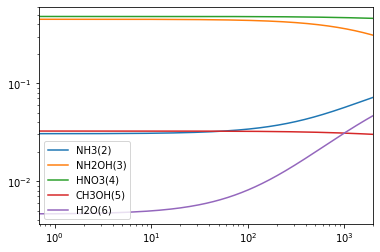

In [44]:
data[gas_species[0:5]].plot(logy=True, logx=True)

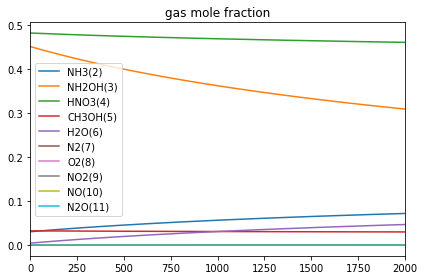

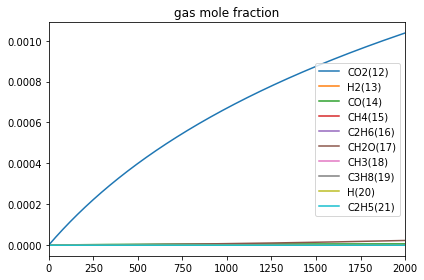

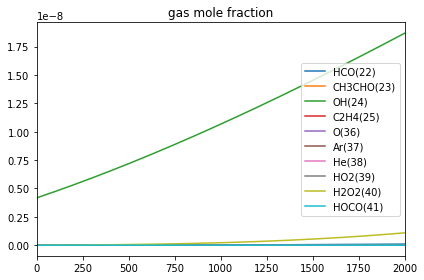

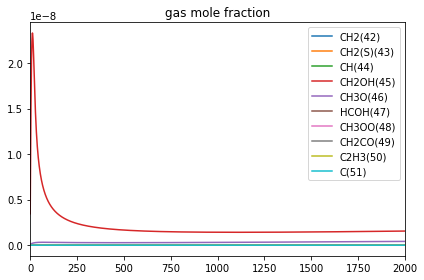

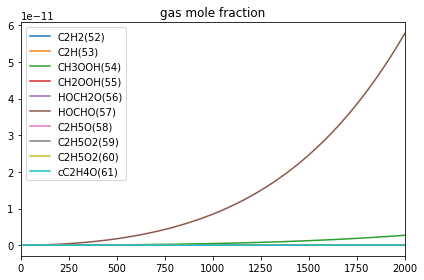

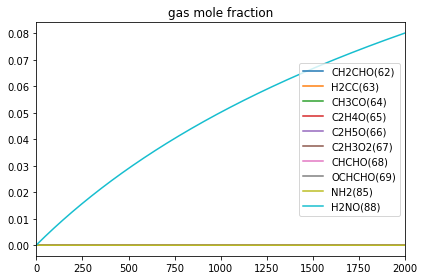

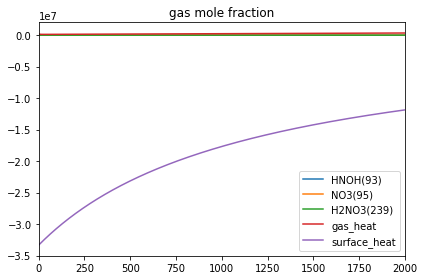

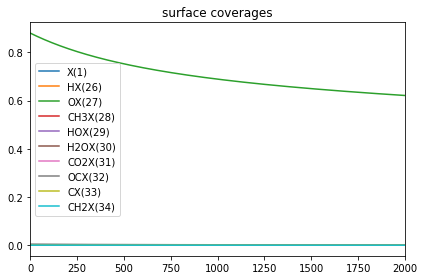

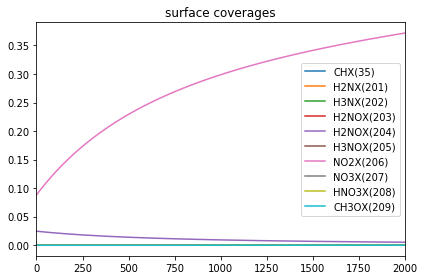

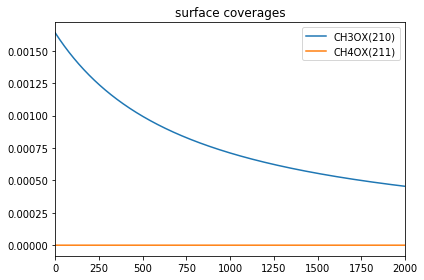

In [45]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='gas mole fraction', logy=False)
    plt.tight_layout()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='surface coverages', logy=False)
    plt.tight_layout()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()

In [46]:
gas.species('NO2(9)').composition

{'N': 1.0, 'O': 2.0}

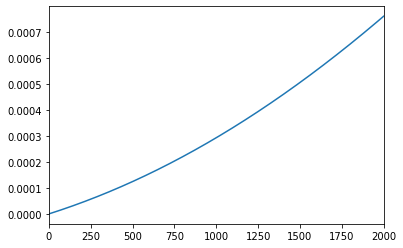

In [47]:
data['NO2(9)'].plot()

In [48]:
(data[specs].max()>0.01)

NH3(2)           True
NH2OH(3)         True
HNO3(4)          True
CH3OH(5)         True
H2O(6)           True
                ...  
CH3OX(209)      False
CH3OX(210)      False
CH4OX(211)      False
gas_heat         True
surface_heat    False
Length: 87, dtype: bool

In [49]:
data.loc[0]

Distance (mm)    0.000000e+00
T (C)            4.000223e+02
P (atm)          1.000000e+00
Ne               0.000000e+00
NH3(2)           3.051026e-02
                     ...     
CH3OX(210)       1.637050e-03
CH4OX(211)       4.170907e-08
gas_heat         2.316014e+05
surface_heat    -3.335483e+07
alpha            1.006992e+00
Name: 0, Length: 92, dtype: float64